In [1]:
import emcee 
import tqdm
import torch 
import torch.nn as nn
import flowtorch.bijectors as bij
import flowtorch.distributions as dist
import flowtorch.parameters as params
from scipy.special import logsumexp
import numpy as np 
import matplotlib.pylab as plt 
import scipy.stats as ss 
from sklearn.preprocessing import PolynomialFeatures
import random

# Set the seed
random.seed(42)
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 12

# Setup Quantities

In [2]:
PARAMS_2 = np.array([0.0, 2.0, -1.0])
PARAMS_3 = np.array([0.0, 0.0, 2.0, -1.0])
NSAMPLES = 2000
BURNIN = 0.25
DISCARD = int(BURNIN * NSAMPLES)
XMIN = 0.0
XMAX = 4.0 
EPS = 0.75
p = 4 # fourth order polynomial
PARAMS_p = np.random.randn(p+1)

# Functions

In [3]:
def glm_evidence(data, design, covariance):
    """
    Computes the log marginal likelihood (evidence) of the data under a Gaussian linear model (GLM) with 
    a Gaussian prior on the parameters.

    Parameters:
    ----------
    data : ndarray
        A 1D array of shape (N,) representing the observed data.
    design : ndarray
        A 2D array of shape (N, D) representing the design matrix, where N is the number of observations and D is the number of features.
    covariance : ndarray
        A 2D array of shape (N, N) representing the covariance matrix of the noise in the observations.

    Returns:
    -------
    log_evidence : float
        The log of the marginal likelihood (evidence) of the data given the model, prior, and noise covariance.
    
    Notes:
    ------
    The function assumes a Gaussian prior on the model parameters with mean zero and identity covariance. 
    The log marginal likelihood is computed by integrating out the parameters, resulting in a marginal distribution 
    that depends on the prior, the design matrix, and the noise covariance.
    """

    priormean = np.zeros(design.shape[1])
    priorcov = np.eye(design.shape[1])
    mean = design @ priormean 
    cov = covariance + design @ priorcov @ design.T 
    dist = ss.multivariate_normal(mean, cov)
    return dist.logpdf(data)

def generate_data(params, xmin=0, xmax=2, ndata=50, eps=0.02):
    """
    Generate synthetic data using a polynomial model with Gaussian noise.
    
    Parameters
    ----------
    params : array-like
        Coefficients of the polynomial model. The length of this array determines
        the degree of the polynomial.
    xmin : float, optional
        The minimum x-value of the generated data (default is 0).
    xmax : float, optional
        The maximum x-value of the generated data (default is 2).
    ndata : int, optional
        The number of data points to generate (default is 50).
    eps : float, optional
        Standard deviation of the Gaussian noise added to the data (default is 0.02).
        
    Returns
    -------
    xvalues : numpy.ndarray
        1D array of x-values over the range [xmin, xmax].
    data : numpy.ndarray
        1D array of generated y-values (data) with added Gaussian noise.
    covariance : numpy.ndarray
        Covariance matrix of the noise, a diagonal matrix with variance `eps**2`.
        
    Notes
    -----
    The function generates `ndata` points of synthetic data based on a polynomial 
    model with the given coefficients `params`. The polynomial degree is determined 
    by the length of `params`. Gaussian noise is added to the data, with variance 
    controlled by `eps`.
    """
    degree = len(params)-1
    xvalues = np.linspace(xmin, xmax, ndata).reshape(-1, 1)
    poly = PolynomialFeatures(degree=degree)
    poly.fit(xvalues)
    design = poly.transform(xvalues)
    covariance = np.eye(ndata) * eps**2 
    data = design @ params + np.random.multivariate_normal(np.zeros(ndata), covariance, 1)
    return xvalues.reshape(-1), data.reshape(-1), covariance

def loglikelihood(theta, data, design, covariance):
    """
    Compute the log-likelihood of the data given a model parameterized by theta.

    Parameters:
    ----------
    theta : array-like
        A 1D array representing the model parameters. These parameters are used to compute 
        the mean of the multivariate normal distribution by multiplying with the design matrix.
    data : array-like
        A 1D array of observed data for which the log-likelihood is computed.
    design : ndarray
        A 2D array (design matrix) where each row corresponds to an observation and each column 
        corresponds to a model feature or predictor. The design matrix is used to compute the mean 
        of the multivariate normal distribution.
    covariance : ndarray
        A 2D square matrix representing the covariance of the data. This matrix captures the 
        uncertainties in the data and is used in the multivariate normal distribution.

    Returns:
    -------
    float
        The log-likelihood value, which represents the log of the probability density function (pdf) 
        evaluated at the observed data, given the model parameters `theta`.

    Notes:
    ------
    - This function assumes a multivariate normal likelihood, where the mean of the distribution is 
      computed as the product of the design matrix and the model parameters `theta`, and the covariance 
      is provided as input.
    - The log-likelihood is used in Bayesian inference and Maximum Likelihood Estimation (MLE) to 
      assess how well the model, parameterized by `theta`, explains the observed data.
    - The `scipy.stats.multivariate_normal` class is used to compute the log-probability density.

    Example:
    --------
    If you have a model with parameter `theta`, design matrix `X`, observed data `y`, and covariance 
    matrix `Sigma`, you can compute the log-likelihood as:
    
    >>> loglikelihood(theta, y, X, Sigma)
    """

    mean = design @ theta
    dist = ss.multivariate_normal(mean, covariance)
    return dist.logpdf(data)

def logprior(theta):
    """
    Compute the log-prior probability density of the model parameters theta under a multivariate normal prior.

    Parameters:
    ----------
    theta : array-like
        A 1D or 2D array representing the model parameters. If a 1D array is passed, it will be converted to 
        a 2D array where each row is a set of parameters. The shape of `theta` is (n_samples, n_params), where
        n_samples is the number of parameter sets and n_params is the number of parameters in each set.

    Returns:
    -------
    float
        The log-prior value of the parameter set `theta`, assuming a multivariate normal prior distribution 
        with zero mean and identity covariance matrix.

    Notes:
    ------
    - This function assumes a standard multivariate normal prior with a mean of zero and an identity 
      covariance matrix, i.e., `N(0, I)`, where `I` is the identity matrix.
    - The log-prior is often used in Bayesian inference to quantify the prior belief about the model parameters 
      before observing any data. It reflects how likely certain parameter values are based on prior knowledge.

    Example:
    --------
    If you have a parameter vector `theta`, you can compute its log-prior as follows:
    
    >>> logprior(theta)
    
    This will return the log of the prior probability density of `theta` assuming a multivariate normal 
    prior with zero mean and identity covariance.

    """
    theta = np.atleast_2d(theta)
    nparams = theta.shape[1]
    mean = np.zeros(nparams)
    cov = np.eye(nparams)
    dist = ss.multivariate_normal(mean, cov)
    return dist.logpdf(theta)

def logposterior(theta, data, design, covariance):
    """
    Compute the log-posterior probability density of the model parameters `theta` given the data, design matrix,
    and covariance matrix. The log-posterior is the sum of the log-likelihood and the log-prior.

    Parameters:
    ----------
    theta : array-like
        A 1D or 2D array representing the model parameters. If a 1D array is passed, it will be converted to
        a 2D array where each row is a set of parameters. The shape of `theta` is (n_samples, n_params), where
        n_samples is the number of parameter sets and n_params is the number of parameters in each set.
        
    data : array-like
        The observed data for which the likelihood is calculated. Should match the number of observations expected
        by the design matrix.

    design : array-like
        The design matrix used to model the relationship between the data and the parameters. Should have shape
        (n_data, n_params), where n_data is the number of observations and n_params is the number of parameters.

    covariance : array-like
        The covariance matrix used in the likelihood calculation. Should be a square matrix of shape
        (n_data, n_data) representing the covariance of the data.

    Returns:
    -------
    float
        The log-posterior value of the parameter set `theta`, computed as the sum of the log-likelihood and 
        the log-prior.

    Notes:
    ------
    - The log-posterior combines information from both the likelihood of the observed data given the parameters
      and the prior belief about the parameters. It is used in Bayesian inference to update the prior belief
      in light of observed data.
    - This function assumes that the `loglikelihood` and `logprior` functions are defined and properly
      compute the log-likelihood and log-prior, respectively.

    Example:
    --------
    To compute the log-posterior for a given parameter set `theta`, data, design matrix, and covariance matrix:

    >>> logposterior(theta, data, design, covariance)

    This will return the log of the posterior probability density of `theta` given the observed data and the prior.

    """
    logl = loglikelihood(theta, data, design, covariance)
    logp = logprior(theta)
    return logl + logp

def sampling(nsamples, initial, data, design, covariance, stepsize=1E-4):
    """
    Perform Markov Chain Monte Carlo (MCMC) sampling using the `emcee` library to explore the parameter space
    and estimate the posterior distribution of the model parameters.

    Parameters:
    ----------
    nsamples : int
        The number of MCMC samples to draw from the posterior distribution.

    initial : array-like
        The initial parameter values to start the MCMC sampling. Should be a 1D array of length `ndim` where
        `ndim` is the number of parameters.

    data : array-like
        The observed data to be used in the likelihood calculation. Should be compatible with the design matrix.

    design : array-like
        The design matrix used in the likelihood calculation. Should have dimensions (n_data, n_params), where
        `n_data` is the number of observations and `n_params` is the number of parameters.

    covariance : array-like
        The covariance matrix used in the likelihood calculation. Should be a square matrix of shape
        (n_data, n_data) representing the covariance of the data.

    stepsize : float, optional, default=1E-4
        The standard deviation of the normal distribution used to initialize the walker positions. Controls the
        size of the initial perturbations to the starting positions.

    Returns:
    -------
    sampler : emcee.EnsembleSampler
        The `emcee` sampler object after running the MCMC. This object contains the samples, chain information,
        and other useful diagnostic information.

    Notes:
    ------
    - The function initializes a set of walkers around the `initial` parameter values, perturbed by a small random
      noise defined by `stepsize`.
    - The `emcee` library is used for the MCMC sampling. It explores the posterior distribution defined by the
      `logposterior` function, which combines the log-likelihood and log-prior.
    - The number of walkers is set to twice the number of dimensions (`ndim`), which is a common practice to ensure
      adequate exploration of the parameter space.
    - Progress of the sampling is shown through a progress bar if the `progress` argument is set to `True`.

    Example:
    --------
    To perform MCMC sampling with 1000 samples starting from an initial guess:

    >>> sampler = sampling(1000, initial_guess, data, design, covariance)

    This will return an `emcee.EnsembleSampler` object containing the MCMC results.

    """
    ndim = len(initial)
    nwalkers = len(initial) * 2
    pos = initial + stepsize * np.random.randn(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior, args=(data, design, covariance))
    sampler.run_mcmc(pos, nsamples, progress=True)
    return sampler

class ThetaTransform:
    """
    A class to perform a linear transformation on parameter samples using a Cholesky decomposition 
    of their covariance matrix. The transformation standardizes the parameters such that they are 
    transformed to a new space where their covariance is the identity matrix.

    Attributes:
    ----------
    ndim : int
        The number of dimensions of the parameter samples.
    pcov : ndarray
        Covariance matrix of the input samples.
    chol : ndarray
        Cholesky decomposition (lower triangular) of the covariance matrix.
    chol_inv : ndarray
        Inverse of the Cholesky decomposition.
    mean : ndarray
        Mean vector of the input samples.
    logdetchol : float
        Logarithm of the determinant of the Cholesky matrix.

    Methods:
    -------
    forward(parameter):
        Transforms the input parameters to the standardized space using the inverse Cholesky transform.
    
    inverse(parameterprime):
        Transforms parameters from the standardized space back to the original parameter space.
    """

    def __init__(self, samples):
        """
        Initializes the ThetaTransform object with parameter samples.
        
        Parameters:
        ----------
        samples : ndarray
            A 2D array of shape (N, D) where N is the number of samples and D is the dimensionality of the parameters.
        """
        self.ndim = samples.shape[1]
        self.pcov = np.cov(samples.T)
        self.chol = np.linalg.cholesky(self.pcov)
        self.chol_inv = np.linalg.inv(self.chol)
        self.mean = np.mean(samples, axis=0).reshape(-1, self.ndim)
        self.logdetchol = np.linalg.slogdet(self.chol)[1]

    def forward(self, parameter):
        """
        Transforms the input parameter(s) to the standardized space using the inverse Cholesky decomposition.
        
        Parameters:
        ----------
        parameter : ndarray
            A 1D or 2D array of shape (D,) or (N, D) where D is the dimensionality of the parameters and N is the number of parameter sets.
        
        Returns:
        -------
        parameterprime : ndarray
            The transformed parameter(s) in the standardized space, with the same shape as the input.
        """
        parameter = parameter.reshape(-1, self.ndim)
        parameterprime = self.chol_inv @ (parameter - self.mean).T
        return parameterprime.T

    def inverse(self, parameterprime):
        """
        Transforms the parameter(s) from the standardized space back to the original parameter space.
        
        Parameters:
        ----------
        parameterprime : ndarray
            A 1D or 2D array of shape (D,) or (N, D) where D is the dimensionality of the standardized parameters and N is the number of parameter sets.
        
        Returns:
        -------
        parameter : ndarray
            The parameter(s) transformed back to the original space, with the same shape as the input.
        """
        parameterprime = parameterprime.reshape(-1, self.ndim)
        parameter = self.chol @ parameterprime.T + self.mean.T
        return parameter.T

    
def build_network(hidden=(32, 32, 32)):
    """Creates a function to do the mapping

    Args:
        hidden (tuple, optional): Number of hidden layers. Defaults to (32, 32, 32).

    Returns:
        flowtorch.lazy.lazy: a composition of bijectors
    """

    transforms = bij.Compose(
        bijectors=[
            bij.AffineAutoregressive(
                params.DenseAutoregressive(hidden_dims=hidden, nonlinearity=nn.Tanh),
            ),
            bij.AffineAutoregressive(
                params.DenseAutoregressive(hidden_dims=hidden, nonlinearity=nn.Tanh),
            ),
            bij.AffineAutoregressive(
                params.DenseAutoregressive(hidden_dims=hidden, nonlinearity=nn.Tanh),
            ),
        ]
    )
    return transforms

class NormFlow:
    def __init__(self, samples):

        ndim = samples.shape[1]
        mean = torch.zeros(ndim)
        std = torch.ones(ndim)
        self.dataset = torch.tensor(samples, dtype=torch.float)
        dist_x = torch.distributions.Independent(
            torch.distributions.Normal(mean, std), 1
        )
        bijector = build_network(hidden=(16, 16, 16))
        self.dist_y = dist.Flow(dist_x, bijector)

    def training(self, lr: float = 5e-3, nsteps: int = 1000) -> list:
        """Train the normalising flow

        Args:
            lr (float, optional): the learning rate. Defaults to 5e-3.
            nsteps (int, optional): the number of steps. Defaults to 1000.

        Returns:
            list: a list of the loss values at each iteration.
        """
        optimizer = torch.optim.Adam(self.dist_y.parameters(), lr=lr)
        record = []
        interval = divmod(nsteps, 20)[0]
        with tqdm.trange(nsteps) as bar:
            for step in bar:
                optimizer.zero_grad()
                loss = -self.dist_y.log_prob(self.dataset).mean()
                loss.backward()
                optimizer.step()
                record.append(loss.item())
                postfix = dict(Loss=f"{loss.item():.3f}")
                bar.set_postfix(postfix)
        return record


    def logpdf(self, parameter: np.ndarray) -> np.ndarray:
        """Calculates the log-probability of the flow given a sample.

        Args:
            parameter (np.ndarray): a test point in Cosmological parameter space.

        Returns:
            np.ndarray: the log-probability value.
        """
        p_tensor = torch.tensor(parameter, dtype=torch.float)
        return self.dist_y.log_prob(p_tensor).detach().numpy()

def evidence_estimate(samples, log_post, trainflow=False, lr=1E-3, nsteps=3000, nsamplesflow=10000):
    """
    Estimate the Bayesian model evidence (marginal likelihood) using transformed samples 
    and log-posterior values, with the option to use a normalizing flow model for prior density estimation.

    Parameters:
    ----------
    samples : array-like
        An array of shape (n_samples, n_params) containing the MCMC samples of the model parameters.
        Each row corresponds to a set of parameter values.
    
    log_post : array-like
        An array of shape (n_samples,) containing the log-posterior values for each sample in `samples`.

    trainflow : bool, optional, default=False
        A flag to indicate whether to use a normalizing flow model to estimate the prior probability density
        for the transformed samples. If set to `True`, a flow-based model is trained and used to estimate
        `log_pdf_prime`. If `False`, a standard multivariate normal prior is assumed.

    lr : float, optional, default=1E-3
        The learning rate for training the normalizing flow model, if `trainflow` is set to `True`.

    nsteps : int, optional, default=3000
        The number of optimization steps for training the normalizing flow model, if `trainflow` is set to `True`.

    Returns:
    -------
    logevidence : float
        The natural logarithm of the Bayesian evidence (marginal likelihood). This value provides a measure
        of how well the model fits the data, marginalized over the parameter space.

    Notes:
    ------
    - The function first transforms the `samples` to a new space using the `ThetaTransform` class, which normalizes
      the covariance structure of the samples.
    - If `trainflow` is `True`, a normalizing flow model (`NormFlow`) is trained to estimate the log probability density
      of the transformed samples (`log_pdf_prime`). The flow is trained using the specified learning rate (`lr`)
      and number of optimization steps (`nsteps`).
    - If `trainflow` is `False`, the log-prior is computed assuming a standard multivariate normal prior.
    - The evidence is computed using the log-determinant of the Cholesky decomposition from the transformation,
      and the log-posterior values with either the prior or flow-based density.

    Example:
    --------
    To estimate the log evidence using MCMC samples and train a normalizing flow:

    >>> logevidence = evidence_estimate(mcmc_samples, log_posteriors, trainflow=True, lr=1E-3, nsteps=5000)

    This will return the log evidence of the model, using a trained flow to estimate the log-prior in the transformed space.

    """

    nsamples = samples.shape[0]
    
    if trainflow:
        nsamples_prime = min([nsamples, nsamplesflow])
        print(f'We are using {nsamples_prime} samples in the Normalising Flow.')
        
        idx = random.sample(range(0, nsamples), nsamples_prime)
        samples_chosen = samples[idx]
        transform = ThetaTransform(samples_chosen)
        samples_prime = transform.forward(samples_chosen)
        
        flow = NormFlow(samples_prime)
        flow.training(lr=lr, nsteps=nsteps)
        log_pdf_prime = flow.logpdf(samples_prime)
        
        logevidence = transform.logdetchol + logsumexp(log_post[idx] - log_pdf_prime) - np.log(nsamples_prime)
        
    else:
        
        transform = ThetaTransform(samples)
        samples_prime = transform.forward(samples)
        log_pdf_prime = logprior(samples_prime)
        log_sum_exp = logsumexp(log_post - log_pdf_prime)
        logevidence = transform.logdetchol +  log_sum_exp - np.log(nsamples)
        print(f'log-sum-exp term is {log_sum_exp:.3f}')
        
    print(f'log-determinant of the Cholesky factor is {transform.logdetchol:.3f}')
    
    return logevidence

# Data and Design Matrics (Models)

In [4]:
xvalues, data, datacov = generate_data(PARAMS_2, xmin=XMIN, xmax=XMAX, eps=EPS)

In [5]:
design_order_2 = PolynomialFeatures(degree=2).fit_transform(xvalues.reshape(-1,1))
design_order_3 = PolynomialFeatures(degree=3).fit_transform(xvalues.reshape(-1,1))
design_order_p = PolynomialFeatures(degree=p).fit_transform(xvalues.reshape(-1,1))

# Sampling

In [6]:
sampler_2 = sampling(NSAMPLES, PARAMS_2, data, design_order_2, datacov)

100%|███████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 376.87it/s]


In [7]:
sampler_3 = sampling(NSAMPLES, PARAMS_3, data, design_order_3, datacov)

100%|███████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 294.31it/s]


In [8]:
sampler_p = sampling(NSAMPLES, PARAMS_p, data, design_order_p, datacov)

100%|███████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 238.88it/s]


# Evidence Comparison

In [9]:
samples_2  = sampler_2.get_chain(discard=DISCARD, flat=True)
log_post_2 = sampler_2.get_log_prob(discard=DISCARD, flat=True)

samples_3  = sampler_3.get_chain(discard=DISCARD, flat=True)
log_post_3 = sampler_3.get_log_prob(discard=DISCARD, flat=True)

samples_p  = sampler_p.get_chain(discard=DISCARD, flat=True)
log_post_p = sampler_p.get_log_prob(discard=DISCARD, flat=True)

### Quadratic Evidence

In [10]:
glm_evidence(data, design_order_2, datacov)

-57.48981608876696

In [11]:
evidence_estimate(samples_2, log_post_2, trainflow=False)

log-sum-exp term is -41.207
log-determinant of the Cholesky factor is -7.178


-57.490615770115944

In [12]:
evidence_estimate(samples_2, log_post_2, trainflow=True, lr=1e-3, nsteps=3000, nsamplesflow=10000)

We are using 9000 samples in the Normalising Flow.


100%|████████████████████████████████████████████████████████████████████████| 3000/3000 [01:26<00:00, 34.57it/s, Loss=4.112]

log-determinant of the Cholesky factor is -7.178


-57.457018077118555

### Cubic Evidence

In [13]:
glm_evidence(data, design_order_3, datacov)

-58.52034976621188

In [14]:
evidence_estimate(samples_3, log_post_3, trainflow=False)

log-sum-exp term is -39.054
log-determinant of the Cholesky factor is -10.074


-58.52071427984631

In [15]:
evidence_estimate(samples_3, log_post_3, trainflow=True, lr=1e-3, nsteps=3000, nsamplesflow=10000)

We are using 10000 samples in the Normalising Flow.


100%|████████████████████████████████████████████████████████████████████████| 3000/3000 [02:17<00:00, 21.90it/s, Loss=5.439]


log-determinant of the Cholesky factor is -10.082


-58.51459930949328

### Quartic Evidence

In [16]:
glm_evidence(data, design_order_p, datacov)

-61.52278729088876

In [17]:
evidence_estimate(samples_p, log_post_p, trainflow=False)

log-sum-exp term is -38.681
log-determinant of the Cholesky factor is -13.228


-61.52406054668519

In [18]:
evidence_estimate(samples_p, log_post_p, trainflow=True, lr=1e-3, nsteps=3000, nsamplesflow=10000)

We are using 10000 samples in the Normalising Flow.


100%|████████████████████████████████████████████████████████████████████████| 3000/3000 [02:06<00:00, 23.77it/s, Loss=6.653]

log-determinant of the Cholesky factor is -13.221


-60.999026697973505

# Plot Data and Best Fit

In [19]:
bestfit_2 = generate_data(samples_2.mean(0), xmin=XMIN, xmax=XMAX, ndata=1000, eps=1E-10)
bestfit_3 = generate_data(samples_3.mean(0), xmin=XMIN, xmax=XMAX, ndata=1000, eps=1E-10)
bestfit_p = generate_data(samples_p.mean(0), xmin=XMIN, xmax=XMAX, ndata=1000, eps=1E-10)

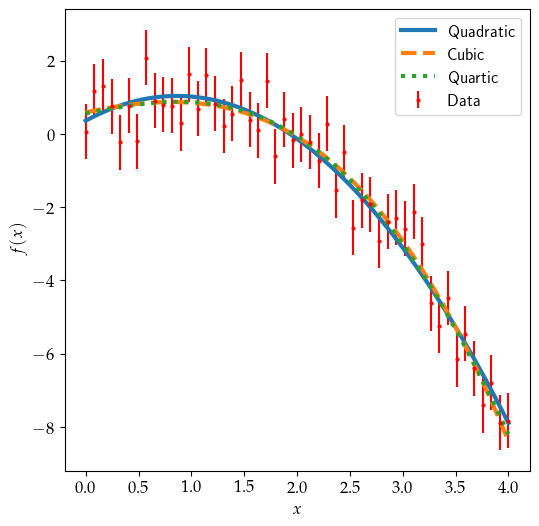

In [21]:
plt.figure(figsize=(6,6))
plt.errorbar(xvalues, data, yerr=EPS, fmt='ro', markersize = 2, label = 'Data')
plt.plot(bestfit_2[0], bestfit_2[1], lw = 3, label = 'Quadratic', linestyle = '-')
plt.plot(bestfit_3[0], bestfit_3[1], lw = 3, label = 'Cubic', linestyle = '--')
plt.plot(bestfit_p[0], bestfit_p[1], lw = 3, label = 'Quartic', linestyle = ':')
plt.ylabel(r'$f(x)$', fontsize = fontSize)
plt.xlabel(r'$x$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':12})
plt.savefig('plots/glm.pdf', bbox_inches = 'tight')
plt.show()